In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from numba import jit
from scipy import interpolate

In [3]:
# general work flow
# read in CSV file
mcsol = genfromtxt('mcsol.csv',delimiter=',')
print(mcsol.shape)

(401,)


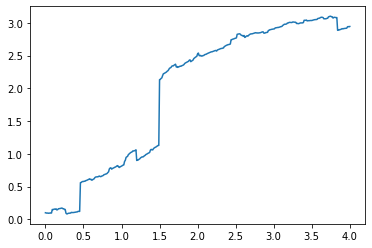

In [4]:
# constant diffusion
g = 0.25

# levy alpha parameter
alpha = 1.0

# time step
h = 0.01

# time vector
tvec = np.arange(mcsol.shape[0])*hp

plt.plot(tvec, mcsol)
plt.show()

In [5]:
# for stretch = 1, this is an equispaced grid on the closed interval [-lmax, lmax]
# for stretch > 1, this is a way to create a non-equispaced grid on [-lmax, lmax]
#                  that is highly concentrated near the origin
npts = 1601
stretch = 1.0
lmax = 800

du = 2.0/(npts - 1)
startvec = -1.0 + np.arange(npts)*du
uvec = lmax*np.sign(startvec)*(np.abs(startvec)**stretch)

# this is a scaling factor used in all the collocation functions below
zeta = 1.0

In [6]:
# CHARACTERISTIC FUNCTION OF THE CAUCHY PDF,
# looks like an UNNORMALIZED LAPLACE PDF, 
# beautiful but sadly non-differentiable at the origin
# def xi(u):
#     return np.exp(-np.abs(u/zeta))

# CHARBONNIER FUNCTIONS, smoothed versions of the above unnormalized Laplace PDF
@jit
def xi(u):
    return np.exp(-(np.sqrt((u/zeta)**2 + 0.01) - 0.1))


C:\Users\haris\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


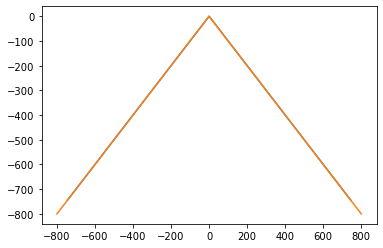

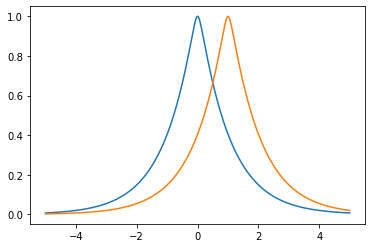

In [7]:
# comparing, on a log scale, our chosen collocation function versus the unnormalized Laplace
plt.plot(uvec, np.log(xi(uvec)))
plt.plot(uvec, -np.abs(uvec/zeta))
plt.show()

# checking to see how much overlap we have on our grid in u space
uuvec = np.linspace(-5,5,401)
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 0]))
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 1]))
plt.show()

In [8]:
# all the matrices are defined in the notes
udiffmat = (np.expand_dims(uvec,0) - np.expand_dims(uvec,0).T)
a = xi(udiffmat)
am1 = xi(udiffmat - 1)
ap1 = xi(udiffmat + 1)
am2 = xi(udiffmat - 2)
ap2 = xi(udiffmat + 2)
b = 0.5*h*(ap1 - am1) @ np.diag(uvec) + 0.125*h**2*(am2 - 2*a + ap2) @ np.diag(uvec**2)
d = np.diag(np.exp(-h*np.abs(uvec*g)**alpha))

In [9]:
# operator splitting
propagator = np.linalg.inv(a - d @ b.T) @ d @ a

# check stability of propagator
np.max(np.abs(np.linalg.eig(propagator)[0]))

# no splitting -- warning, probably unstable
# propagator = np.linalg.inv(a) @ d @ (a + b)

1.0000000000000027

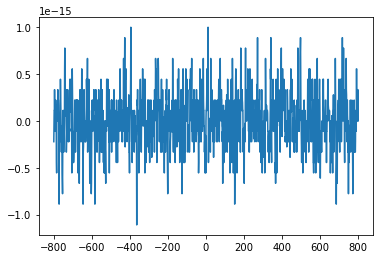

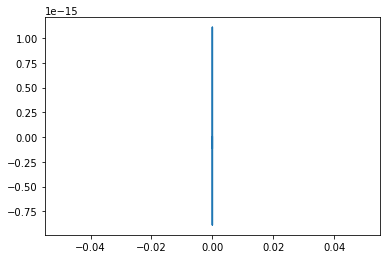

In [10]:
# set up initial condition, a mean-zero Gaussian (characteristic function)
initvar = 0.05
# psi0 = np.exp(-(initvar**2/2)*uvec**2)
# psi0 = np.ones(uvec.shape)
psi0 = np.exp(1j*0.5*uvec)

# represent initial condition using collocation functions
gamma = np.linalg.inv(a) @ psi0

# check to see how well we can reconstruct the initial condition 
plt.plot(np.real(uvec), np.real(a @ gamma - psi0))
plt.show()
plt.plot(np.imag(uvec), np.imag(a @ gamma - psi0))
plt.show()



In [11]:
# set up time stepping
# store all the characteristic functions
numsteps = 401
regsig = 0.005
gammax0 = np.exp(1j*np.outer(uvec,mcsol[0:(numsteps-1)]))
gammax0 = np.expand_dims(np.exp(-(regsig**2)*(uvec**2)/2),1) * gammax0
gammax1 = propagator @ gammax0

# gammamat = np.zeros((npts, numsteps))
# gammamat[:, 0] = gamma

# for iii in range(numsteps):
#     gammamat[:, iii+1] = propagator @ gammamat[:, iii]
#     normalization = a[(npts-1)//2, :] @ gammamat[:, iii+1]
#     print(normalization)
    
#     # forcefully renormalized at every time step
#     # we'd like to avoid doing this, as this is a total hack:
#     # gammamat[:, iii+1] /= normalization
#     # print( a[(npts-1)//2, :] @ gammamat[:, iii+1] )


(2000,)


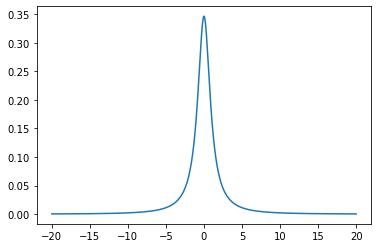

In [12]:
xmax = 20
xpts = 2000
xvec = np.linspace(-xmax, xmax, xpts)
ftmat = np.exp(-1j * np.expand_dims(uvec,1) @ np.expand_dims(xvec, 0))

base = np.loadtxt('charboninv.csv')
print(base.shape)
plt.plot(xvec,base)

charboninv = interpolate.interp1d(xvec, base)

In [75]:
# allpdfs = interpolate.interp1d(xvec, np.real(gammax1.T @ ftmat))
# testll = np.log( np.diag(allpdfs(mcsol[1:])) * np.array(list(map(charboninv, mcsol[1:]))) )

# print( np.sum(testll) )

908.4240232012171


In [76]:
# loglik = np.zeros(numsteps-1)
# for j in range(numsteps-1):
#     thispdf = interpolate.interp1d(xvec, np.real( gammax1[:,j] @ ftmat ))
#     loglik[j] = np.log( thispdf(mcsol[j+1]) * charboninv(mcsol[j+1]) )

# print(np.sum(loglik))

908.4240232012171


In [13]:
charbs = np.array(list(map(charboninv, mcsol[1:]))) 
print(charbs.shape)

(400,)


In [18]:
# write a function
@jit
def myinterp(xvec, fval, xnew):
    inds = np.searchsorted(xvec, xnew)
    ar = np.arange(xnew.shape[0])
    dx = xvec[1] - xvec[0]
    fnew = (np.diag(fval[:,inds-1]) * (xvec[inds] - xnew) + np.diag(fval[:,inds]) * (xnew - xvec[inds-1]))/dx
    return fnew

@jit
def loglik(theta):
    # all the matrices are defined in the notes
    udiffmat = (np.expand_dims(uvec,0) - np.expand_dims(uvec,0).T)
    a = xi(udiffmat)*(1+0j)
    am1 = xi(udiffmat - theta)*(1+0j)
    ap1 = xi(udiffmat + theta)*(1+0j)
    am2 = xi(udiffmat - 2*theta)*(1+0j)
    ap2 = xi(udiffmat + 2*theta)*(1+0j)
    cuvec = uvec*(1+0j)
    b = (1+0j)*0.5*h*(ap1 - am1) @ np.diag(cuvec) + 0.125*h**2*(am2 - 2*a + ap2) @ np.diag(cuvec**2)
    d = (1+0j)*np.diag(np.exp(-h*np.abs(uvec*g)**alpha))
    # propagator = np.linalg.inv(a - d @ b.T) @ d @ a

    numsteps = 401
    regsig = 0.005
    gammax0 = np.exp(1j*np.outer(uvec,mcsol[0:(numsteps-1)]))
    gammax0 = np.expand_dims(np.exp(-(regsig**2)*(uvec**2)/2),1) * gammax0
    gammax1 = np.linalg.solve(a - d @ b.T, d @ a @ gammax0) 
    allpdfs = myinterp(xvec, np.real(gammax1.T @ ftmat), mcsol[1:])
    
    loglik = np.log( allpdfs * charbs )
                    
    return np.sum(loglik)

In [19]:
thetavec = np.linspace(0.5,1.5,100)

In [20]:
llvec = np.array(list(map(loglik, thetavec)))

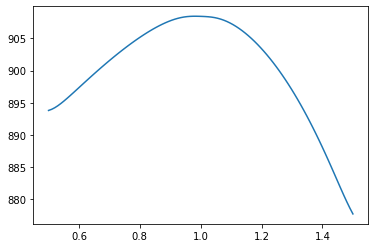

In [21]:
plt.plot(thetavec,llvec)

In [24]:
thetavec[np.argmax(llvec)]

0.9848484848484849

In [26]:
np.argsort([3.0,4.0,-1.0,0.0,3.0])[1]

3